### Base/ Given Accuracy  :89.11 </br>
### Base/ Given  Validation Accuracy  : 82.76 </br>

## Assignment 6A accuracy:</br>
### Final  Accuracy  : 91.17</br>
### Final  Validation Accuracy  : 83.36</br>


## Assignment 6B(different kinds of convolutions) accuracy:</br>
### Final  Accuracy  : 89.03</br>
### Final  Validation Accuracy  : 75.35</br>

### Epochs kept constant: 50


In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential,Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D,DepthwiseConv2D,SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout,Input,concatenate,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


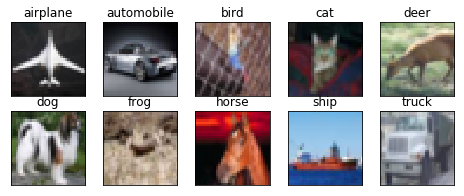

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
# Define the model
input_img = Input(shape=(32,32,3))

# Conv Block1
l1 = Convolution2D(32, 3, 1, use_bias=False,name='Separablelayer1',border_mode='same', input_shape=(32, 32, 3))(input_img)  #3       32
l1 = BatchNormalization()(l1)
l1 = Activation('relu')(l1)
l1 = Dropout(0.25)(l1)

l2 = Convolution2D(32, 1, 3, use_bias=False,name='Separablelayer2',border_mode='same')(l1)        #5             32
l2 = BatchNormalization()(l2)
l2 = Activation('relu')(l2)
l2 = Dropout(0.25)(l2)

l3 = DepthwiseConv2D(3, (1,1), use_bias=False,name='depthwiselayer',padding='same')(l2)         #7                      32
l3 = BatchNormalization()(l3)
l3 = Activation('relu')(l3)
l3 = Dropout(0.25)(l3)

l4 = SeparableConv2D(32, 3, 3, use_bias=False,name='spatial-depthwiselayer-1cross1',border_mode='same')(l3)         #7                      32
l4 = BatchNormalization()(l4)
l4 = Activation('relu')(l4)
l4 = Dropout(0.25)(l4)

# Transition Block1
m1 = MaxPooling2D(pool_size=(2, 2))(l4)                                                  #14             16
#model.add(Convolution2D(32, 1, 1))


# Conv Block2  #group conv
l5 = Convolution2D(128, 3, 3, use_bias=False,name='groupl1layer1',border_mode='same',dilation_rate = 1)(m1)          #16          16
l5 = BatchNormalization()(l5)
l5 = Activation('relu')(l5)
l5 = Dropout(0.25)(l5)

l6 = Convolution2D(128, 3, 3, use_bias=False,name='group1layer2',border_mode='same',dilation_rate = 2)(m1)            #18       16
l6 = BatchNormalization()(l6)
l6 = Activation('relu')(l6)
l6 = Dropout(0.25)(l6)

c1 = concatenate([l5, l6])
# Transition Block2
m2 = MaxPooling2D(pool_size=(2, 2))(c1)                                                       #36       8
m2 = Convolution2D(32, 1, 1)(m2)
m2 = BatchNormalization()(m2)


# Conv Block3  # group conv
l7 = Convolution2D(64, 3, 3, use_bias=False,name='groupl2layer1',border_mode='same')(m2)               #38     8
l7 = BatchNormalization()(l7)
l7 = Activation('relu')(l7)
l7 = Dropout(0.25)(l7)

l8 = Convolution2D(64, 5, 5, use_bias=False,name='groupl2layer2',border_mode='same')(m2)               #40     8
l8 = BatchNormalization()(l8)
l8 = Activation('relu')(l8)
l8 = Dropout(0.25)(l8)

c2 = concatenate([l7, l8])

# Final Block3
f = Convolution2D(10, 1, 1)(c2)
f = BatchNormalization()(f)
f = Dropout(0.25)(f)
f = GlobalAveragePooling2D()(f)

#model.add(Flatten())

f = Activation('softmax')(f)
                  
model = Model(inputs=input_img, outputs=f)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0627 04:23:53.960993 140096423352192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 04:23:53.999749 140096423352192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), use_bias=False, name="Separablelayer1", input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
W0627 04:23:54.010991 140096423352192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 04:23:54.04

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Separablelayer1 (Conv2D)        (None, 32, 32, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         Separablelayer1[0][0]            
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':
W0627 04:23:58.494372 140096423352192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will

Epoch 1/50
390/390 [==============================] - 39s 100ms/step - loss: 1.6371 - acc: 0.4304 - val_loss: 2.4211 - val_acc: 0.2424
Epoch 2/50
390/390 [==============================] - 34s 87ms/step - loss: 1.3163 - acc: 0.5597 - val_loss: 1.7273 - val_acc: 0.3730
Epoch 3/50
390/390 [==============================] - 34s 87ms/step - loss: 1.1457 - acc: 0.6171 - val_loss: 1.6915 - val_acc: 0.3874
Epoch 4/50
390/390 [==============================] - 34s 87ms/step - loss: 1.0310 - acc: 0.6537 - val_loss: 1.9280 - val_acc: 0.3545
Epoch 5/50
390/390 [==============================] - 34s 87ms/step - loss: 0.9497 - acc: 0.6818 - val_loss: 1.2954 - val_acc: 0.5399
Epoch 6/50
390/390 [==============================] - 34s 88ms/step - loss: 0.8858 - acc: 0.7030 - val_loss: 1.5027 - val_acc: 0.4878
Epoch 7/50
390/390 [==============================] - 34s 87ms/step - loss: 0.8281 - acc: 0.7217 - val_loss: 1.4646 - val_acc: 0.4834
Epoch 8/50
390/390 [==============================] - 34s 87m

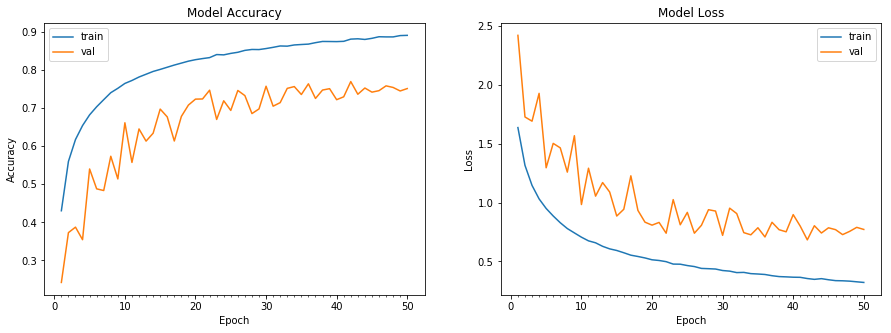

Accuracy on test data is: 75.08


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))